## Yield Spread Model


We try to use the transformer or lstm model to predict the yield spread for the next trade, given information such as the price, yield spread etc about recent trades. 

The implementation was derived from the keras tutorial on [transformers](https://keras.io/examples/structured_data/movielens_recommendations_transformers/) and the transformer [tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) from pytorch.  I also referenced this [blog](https://jalammar.github.io/illustrated-transformer/) post on transformers

In [144]:
import pandas as pd
import numpy as np

from google.cloud import bigquery
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras import backend
import plotly.graph_objects as go
from IPython.display import display, HTML

np.random.seed(10)

In [145]:
bq_client = bigquery.Client()

### Checking if GPU is available

In [146]:
tf.test.is_gpu_available()

True

#### Hyper-parameters for the model
The batch size and learning rate have an impact on the smoothness of convergence of the model.\
Larger the batch size the smoother the convergence. For a larger batch size we need a higher learning rate and vice-versa

In [163]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.001
NUM_EPOCHS = 500
SEQUENCE_LENGTH = 32
NUM_FEATURES= 5
STEP_SIZE = 1
HIDDEN_LAYERS = [400, 200, 50, 25]
DROPOUT_RATE = 0
NUM_HEADS = 1
BATCH_SIZE = 1000

In [148]:
# Model type either Transformer or LSTM
# Setting this parameter will decide which architecture we use for
# the prediction of yield spreads
MODEL_TYPE = "Transformer"

#### Query to fetch data from BigQuery
This query returns the information about all the trades for CUSIPS.\
We also calculate the yield spreads using this query

In [149]:
DATA_QUERY = """ WITH 
        --- Do a join to get previous trades, add sequence number and then DISTINCT
        --- I believe this eliminates the Cartesian product while not collapsing distinct
        --- but otherwise identical trades
          past_trades_table as (SELECT DISTINCT
          latest.cusip as latest_cusip, latest.trade_date as latest_trade_date, latest.time_of_trade as latest_time_of_trade,
          past.cusip as past_cusip,
          past.sequence_number as past_sequence_number,
          past.trade_date as past_trade_date, 
          past.time_of_trade as past_time_of_trade, 
          past.yield as past_yield,
          past.dollar_price as past_dollar_price, 
          past.par_traded as past_par_traded, 
          past.trade_type as past_trade_type,
          past.transaction_type as transaction_type,
          date_diff(latest.trade_date,past.trade_date, day) as days_ago 

          FROM `eng-reactor-287421.MSRB.msrb_daily_replay_files` AS latest
          LEFT JOIN `eng-reactor-287421.MSRB.msrb_daily_replay_files` AS past
          ON latest.cusip = past.cusip
          WHERE (past.publish_date <= latest.trade_date) 
          OR (past.publish_date = latest.trade_date) 
          AND (past.publish_time <= latest.time_of_trade) 
          AND (past.transaction_type NOT IN ("R"))
          AND (past.yield IS NOT NULL)
          AND (past.trade_type IS NOT NULL)
          AND (past.dollar_price IS NOT NULL)
          AND (past.par_traded IS NOT NULL)
          AND (past.trade_date <= '2020-05-04')
          ),

          --- Joining the created table with index yield 
          --- on trade date to create the yield spreads
          past_trade_yield as (
            SELECT  past_trades_table.latest_cusip,
            past_trades_table.latest_trade_date,
            past_trades_table.latest_time_of_trade,
            past_trades_table.past_trade_date,
            past_trades_table.past_time_of_trade,
            (past_trades_table.past_yield - sp_index_yield.ytw) as past_yield_spread,
            past_trades_table.past_dollar_price,
            past_trades_table.past_par_traded,
            past_trades_table.past_trade_type,
            past_trades_table.transaction_type,
            past_trades_table.days_ago
            FROM past_trades_table JOIN `eng-reactor-287421.spBondIndex.sp_muni_index_yield` as sp_index_yield
            ON past_trades_table.past_trade_date = DATE_ADD(sp_index_yield.date, INTERVAL 1 day)
            WHERE sp_index_yield.ytw IS NOT NULL 
            AND past_trades_table.past_yield IS NOT NULL 
            AND past_trades_table.past_par_traded IS NOT NULL
            AND past_trades_table.past_trade_type IS NOT NULL
            AND past_trades_table.past_dollar_price IS NOT NULL
                   
          ),

        --- now with the good joined query aggregate by cusip, date and time 
        past_trades_aggregated as (  
          SELECT latest_cusip, latest_trade_date, latest_time_of_trade,
          ARRAY_AGG(STRUCT (past_trade_date, past_time_of_trade, ROUND(past_yield_spread,4) as yield_spread,
                              past_dollar_price, past_par_traded, past_trade_type,
                              transaction_type, days_ago )
                      ORDER BY past_trade_date ASC, past_time_of_trade ASC
                      ) AS recent_trades
          FROM past_trade_yield
          GROUP BY latest_cusip, latest_trade_date, latest_time_of_trade)

        --- finally take the base trade data table and left join on the 
        --- aggregated history of trades by cusip, date and time

        SELECT base.cusip, 
        past_trades_aggregated.recent_trades
        FROM `eng-reactor-287421.MSRB.msrb_daily_replay_files`AS base
        LEFT JOIN past_trades_aggregated
        ON base.cusip=past_trades_aggregated.latest_cusip
        AND base.trade_date = past_trades_aggregated.latest_trade_date
        AND base.time_of_trade=past_trades_aggregated.latest_time_of_trade
        WHERE base.yield IS NOT NULL
        LIMIT 10000
        """

### DataLoader Class

The DataLoader class grabs the data from BigQuery and returns the dataset as a dataframe. The query creates an array of all trades for every CUSIP. The query drops the trades that have been canceled. We calculate the yield spreads by taking the diffrence of the bond's yield and the yield of the [s&p muni bond index](https://www.spglobal.com/spdji/en/indices/fixed-income/sp-municipal-bond-index/#overview). To test the implementation I have limited the number of rows to 200, this can easily be changed by removing the limit in the DATA_QUERY.

The main driver method of the class is the processData function, which has been implemented as a class method. I decided to implement it as a class method as it can be easily called in other files without creating an instance for the class

The dataset is split into training and testing, with 85% of the data being used to train the model. The parameter that decides the ratio of train test split is defined in the cells above. We create a sequence of 5 trades and feed that into the model. The sequence parameter is defined as a hyper-parameter and can be easily changed. The sequence contains the yield spreads, prices, par traded value, the type of trade, and the number of days ago the trade was executed. Additional features can be added with a few minor tweaks to the source code.  

I do a few blunt normalizations to help the model learn. I multiply the yield spreads by 100 to convert the units to basis points and divide the par trade value by 1000 to reduce the absolute scale. We can try other normalization schemes to see how that affects the learning of the model


In [150]:
class DataLoader(object):
    '''
    Class to load the data from big query 
    and process it to create train and test data
    '''
    def __init__(self,query,client):
        self.query = query
        self.trade_dataframe = None
        self.client = client
        
    @staticmethod
    def createSequence(x):
        '''
        Creates sequence of historical trades
        x : list
        
        This function uses list slicing to create the desired sequence of trades
        If the CUSIP does not have enough trades, we drop it. 
        
        At each iteration, the counter(base) is increased by STEP_SIZE and then the function
        extracts SEQUENCE_LENGTH size chunk of trades to create the sequence.
        
        '''
        chunks = [x[base:base+SEQUENCE_LENGTH]\
                  for base in range(0,len(x), STEP_SIZE)\
                  if len(x[base:base+SEQUENCE_LENGTH]) == SEQUENCE_LENGTH]
        return chunks

    @staticmethod
    def tradeDictToList(trade_dict: dict) -> list:
        '''
        This function converts the recent trades dictionary
        to a list. The SQL array is converted to a dictionary
        when read as a pandas dataframe

        parameters:
        trade_dict : dict
        '''
        trade_type_mapping = {'D':[0,0],'S': [0,1],'P': [1,0]}

        # A few blunt normalizations will experiment with others as well
        # Multiplying the yield spreads by 100 to convert to basis points
        # Dividing the trade value by 1000 to reduce the absolute scale 
        
        trade_list = []
        trade_list.append(trade_dict['yield_spread'] * 100)
        trade_list.append(np.float32(trade_dict['past_par_traded']/1000))        
        trade_list += trade_type_mapping[trade_dict['past_trade_type']]
        trade_list.append(trade_dict['days_ago'])
        
        return np.stack(trade_list)
    
    @staticmethod
    def tradeListToArray(trade_history):
        '''
        parameters:
        trade_history - list
        
        This function creates the trade history array
        '''
        if len(trade_history) == 0:
            return np.array([])
        
        trades_list = [DataLoader.tradeDictToList(entry) for entry in trade_history]
        return np.stack(trades_list)

    
    @staticmethod
    def create_features(x):
        '''
        Returns the SEQUENCE_LENGTH - 1
        elements of the trade history array
        '''
        try:
            return x[:SEQUENCE_LENGTH - 1]
        except Exception as e:
            # debugging code
            print(x)
            raise e

    @staticmethod
    def create_target(x):
        try:
            return x[SEQUENCE_LENGTH-1][0]
        except Exception as e:
            # debugging code
            print(x)
            raise e
        
    def fetchData(self):
        '''
        Function executes the query to fetch data from BigQuery
        and apply helper functions to create the trade history array
        '''
        self.trade_dataframe = self.client.query(self.query).result().to_dataframe()
        self.trade_dataframe['trade_history'] = self.trade_dataframe.recent_trades.apply(self.tradeListToArray)
        self.trade_dataframe.drop(columns=['recent_trades'],inplace=True)
        
    # Class functions do not need an instance of the calss to be called.
    # They are mehtods associated with the class and not the instance
    # and can be called by the class directly
    @classmethod
    def processData(cls,query,client):
        '''
        Class method to process data from bigquery to create
        the train and test set
        '''
        instance = cls(query,client)
        instance.fetchData()
        instance.trade_dataframe.trade_history = instance.trade_dataframe.trade_history.apply(instance.createSequence) 
        
        instance.trade_dataframe = instance.trade_dataframe[['cusip','trade_history']].explode("trade_history",ignore_index=True)
        instance.trade_dataframe = instance.trade_dataframe.dropna()
        
        instance.trade_dataframe['features'] = instance.trade_dataframe['trade_history'].apply(instance.create_features)
        instance.trade_dataframe['target'] = instance.trade_dataframe['trade_history'].apply(instance.create_target)
        instance.trade_dataframe = instance.trade_dataframe.drop(columns=['trade_history'])
        
        random_selection = np.random.rand(len(instance.trade_dataframe.index)) <= TRAIN_TEST_SPLIT
        print("Number of training Samples {}".format(len(instance.trade_dataframe[random_selection])))
        train_data = instance.trade_dataframe[random_selection]
        test_data = instance.trade_dataframe[~random_selection]
        display(train_data.head())
        return train_data,test_data
    
    

In [179]:
if os.path.isfile('test.pkl') and os.path.isfile('train.pkl'):
    train_dataframe = pd.read_pickle('train.pkl')
    test_datframe = pd.read_pickle('test.pkl')
else:
    train_dataframe, test_dataframe = DataLoader.processData(DATA_QUERY,bq_client)

In [180]:
# Shuffling the train set 
train_dataframe = train_dataframe.sample(frac=1)
display(train_dataframe)

,cusip,features,target
33382,64990FXG4,"[[-37.28, 10.0, 0.0, 1.0, 40.0], [8.2199999999...",-103.91
50603,60637ARG9,"[[156.39000000000001, 10.0, 0.0, 1.0, 6.0], [1...",157.19
73492,20773CAR7,"[[318.65999999999997, 20.0, 0.0, 1.0, 20.0], [...",340.11
49533,60637ARG9,"[[156.39000000000001, 20.0, 0.0, 1.0, 5.0], [1...",158.06
5496,167505PA8,"[[136.35, 25.0, 0.0, 0.0, 101.0], [165.8500000...",17.71
...,...,...,...
3912,34073TCF2,"[[440.06, 10.0, 0.0, 0.0, 139.0], [407.36, 10....",455.98
16020,709225CC8,"[[83.66, 20.0, 0.0, 1.0, 34.0], [83.66, 20.0, ...",83.66
38442,60637ARG9,"[[157.29999999999998, 15.0, 0.0, 1.0, 1.0], [1...",166.40
11282,13033LYS0,"[[-33.79, 95.0, 0.0, 0.0, 68.0], [-49.39, 95.0...",-60.73


Changing the dataframe to numpy array so that data can be fed into the input layer of the model

In [181]:
train_data = np.stack(train_dataframe.features.to_numpy())
target = train_dataframe.target.to_numpy()

test_data = np.stack(test_dataframe.features.to_numpy())
test_target =  test_dataframe.target.to_numpy()

In [182]:
print(train_data.shape)
print(target.shape)
print(test_data.shape)

(65401, 31, 5)
(65401,)
(11300, 31, 5)


### Transformer Model

The model is made up of a multi-headed attention layer, with a feed-forward neural network stacked on top of it. 

The input features (yield spreads, price, trade type, par trade value, and days from previous trade) are combined with positional encodings. I used positional encodings as described in the '[Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf)' paper. The embeddings are created as follows. 

<center>
 $\large p_t =
\left\{
	\begin{array}{ll}
		 \sin(\omega_it )  & \mbox{if } i = 2k \\
		 \cos(\omega_it) & \mbox{if } i = 2k +1 
	\end{array}
\right.
$

</center>

Where $\omega$ is defined as follows
<center>
$
\Large \omega_i = \frac{1}{1000 ^ \frac{2i}{d}} \hspace{1cm} \small 0 \leq i \leq d
$

</center>

Here t is the position in the input sequence, and d is the dimension of the encoding. The positional encodings are then added to the input features, before being fed to the multi-headed attention layer.



In [155]:
class Time2Vec(layers.Layer):
    pass

In [164]:
class YieldSpreadModel(object):
    '''
    Class to create the transformer model
    '''
    
    @staticmethod
    def model_input():
        '''
        Creates a dictionary of all the 
        inputs to the model
        '''
        return {
            "features" : layers.Input(name="yield_sequence", shape=((SEQUENCE_LENGTH - 1),NUM_FEATURES), dtype = tf.float32)
        }

        
    @staticmethod
    def input_features(inputs):
        input_features = inputs['features']
        
        if MODEL_TYPE.upper() == "TRANSFORMER":
            positional_encodings = np.array([ [pos/np.power(1000,2*i/NUM_FEATURES) \
                                               for i in range(NUM_FEATURES)]\
                                               for pos in range(SEQUENCE_LENGTH-1)])
            positional_encodings[1:, 0::2] = np.sin(positional_encodings[1:, 0::2])
            positional_encodings[1:, 1::2] = np.cos(positional_encodings[1:, 1::2])
            positional_encodings = tf.convert_to_tensor(positional_encodings, dtype=tf.float32)
            positional_encodings = positional_encodings[None,:,:]

            input_features = input_features + positional_encodings

        return input_features
        
    @classmethod
    def create_model(cls,MODEL_TYPE='TRANSFORMER'):
        '''
        Returns the model to predict the yield spreads
        Depending on the MODEL_TYPE the model can either use
        Transformer or an LSMT to extract information from the sequence
        '''
        
        instance = cls()
        inputs = instance.model_input()
        
        
        if MODEL_TYPE.upper() == 'TRANSFORMER':
            transformer_features = instance.input_features(inputs)
            # Attention layer
            # Key and values are same for self attention
            attention_output = layers.MultiHeadAttention(num_heads=NUM_HEADS, 
                                                         key_dim=transformer_features.shape[2])(transformer_features, transformer_features)

            # Transformer block.
            attention_output = layers.Dropout(DROPOUT_RATE)(attention_output)
            x1 = layers.Add()([transformer_features, attention_output])
            x1 = layers.LayerNormalization()(x1)
            x2 = layers.LeakyReLU()(x1)
            x2 = layers.Dense(units=x2.shape[-1])(x2)
            x2 = layers.Dropout(DROPOUT_RATE)(x2)
            transformer_features = layers.Add()([x1, x2])
            transformer_features = layers.LayerNormalization()(transformer_features)
            features = layers.Flatten()(transformer_features)
        
        elif MODEL_TYPE.upper() == 'LSTM':
            lstm_features = instance.input_features(inputs)
            lstm_layer = layers.LSTM(20, 
                                   activation='tanh',
                                   input_shape=(SEQUENCE_LENGTH,NUM_FEATURES))
            features = lstm_layer(lstm_features)
        
        # The loops is used to create the feed-froward NN
        for LAYER in HIDDEN_LAYERS:
            features = layers.Dense(LAYER)(features)
            features = layers.BatchNormalization()(features)
            features = layers.Activation(activations.tanh)(features)
            #features = layers.Dropout(DROPOUT_RATE)(features)

        outputs = layers.Dense(units=1)(features)
        model = keras.Model(inputs=inputs, outputs=outputs)
        
        return model
    

In [165]:
model = YieldSpreadModel.create_model(MODEL_TYPE)

In [166]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
yield_sequence (InputLayer)     [(None, 31, 5)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.add_8 (TFOpLam (None, 31, 5)        0           yield_sequence[0][0]             
__________________________________________________________________________________________________
multi_head_attention_8 (MultiHe (None, 31, 5)        120         tf.__operators__.add_8[0][0]     
                                                                 tf.__operators__.add_8[0][0]     
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 31, 5)        0           multi_head_attention_8[0][0

In [167]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [168]:
history = model.fit(train_data, target, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,  verbose=2, validation_split=0.2)

Epoch 1/500
53/53 - 2s - loss: 74139.6953 - mean_absolute_error: 170.3352 - val_loss: 68186.0156 - val_mean_absolute_error: 165.6853
Epoch 2/500
53/53 - 0s - loss: 73579.6562 - mean_absolute_error: 168.9594 - val_loss: 67902.6016 - val_mean_absolute_error: 164.9397
Epoch 3/500
53/53 - 0s - loss: 72996.5000 - mean_absolute_error: 167.3024 - val_loss: 67331.2578 - val_mean_absolute_error: 163.3869
Epoch 4/500
53/53 - 0s - loss: 72433.1250 - mean_absolute_error: 165.6643 - val_loss: 67097.7969 - val_mean_absolute_error: 162.8157
Epoch 5/500
53/53 - 0s - loss: 71860.5938 - mean_absolute_error: 163.9738 - val_loss: 67290.5938 - val_mean_absolute_error: 162.7083
Epoch 6/500
53/53 - 0s - loss: 71274.4062 - mean_absolute_error: 162.2346 - val_loss: 66325.1641 - val_mean_absolute_error: 159.9391
Epoch 7/500
53/53 - 0s - loss: 70701.2969 - mean_absolute_error: 160.5701 - val_loss: 66158.2109 - val_mean_absolute_error: 159.3050
Epoch 8/500
53/53 - 0s - loss: 70136.9219 - mean_absolute_error: 158.

In [169]:
_, mae = model.evaluate(test_data, test_target, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

354/354 [==============================] - 1s 2ms/step - loss: 5771.8628 - mean_absolute_error: 14.8559
Test MAE: 14.856


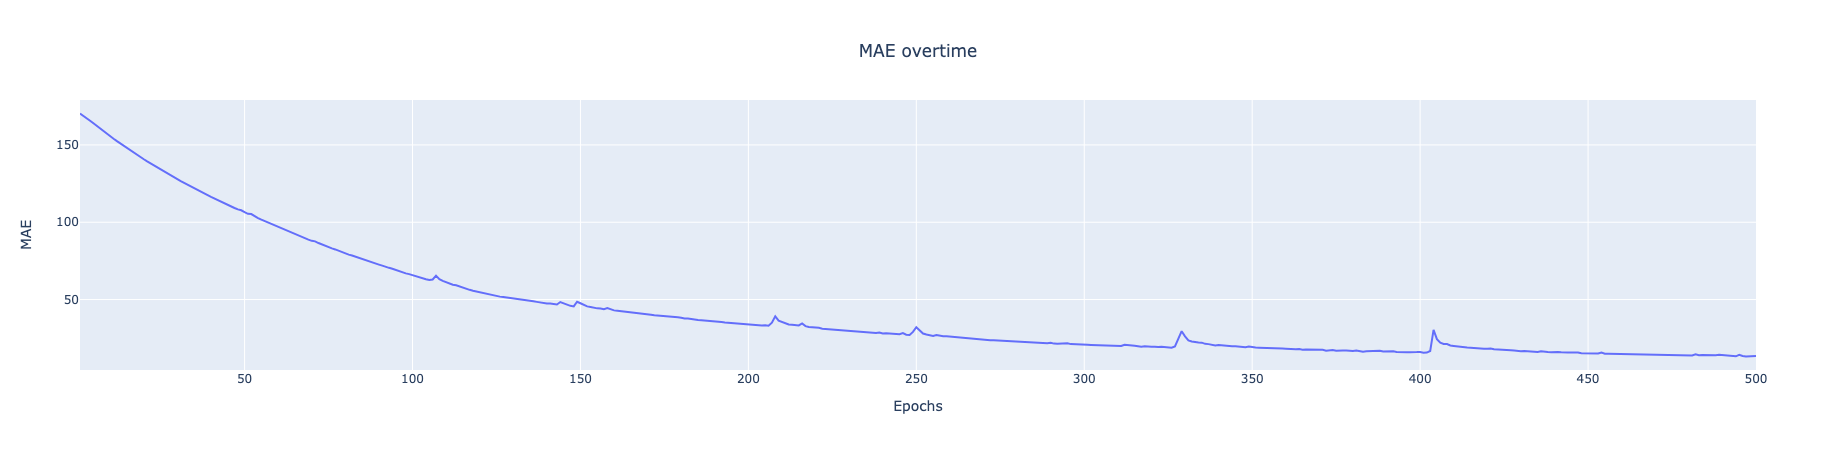

In [170]:
fig = go.Figure(data=go.Scatter(x=list(range(1,len(history.history['mean_absolute_error'])+1)), y = history.history['mean_absolute_error']))
fig.update_layout(title={'text':"MAE overtime", 'y':0.9, 'x':0.5, 'xanchor': 'center','yanchor': 'top'}, xaxis_title="Epochs", yaxis_title="MAE")
fig.show()